### TODO

* Evaluation:
  - [x] ROC AUC
  - [x] Evaluation: precision
* Experiment:
  - [x] Baseline1: predict all link with `None`
  - [x] Baseline2: common neighbor, jaccard coefficient, preferrential attachment ... etc(`#commons`)
  - [x] Method3: each-10% `#1`, each-10% `#2`
  - [x] Method4: each-quad `#1`, each-quad `#2`
  - [x] Method5: distribution

## Package Initialization

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

import math

## Parse & Reformat Dataset

read training data, save to pandas DataFrame

In [0]:
training_data = pd.read_csv('train.csv', sep=',')

In [0]:
training_data

read testing data, save to pandas DataFrame

In [0]:
test_data = pd.read_csv('test.csv', sep=',')

In [0]:
test_data

read node attribute

In [0]:
node_features = pd.read_csv('content.csv', header=None, sep='\t')

In [0]:
node_features

replace node id with attributes in train data and test data

In [0]:
# training data (labels)
labels = list(training_data["label"])
labels = [str(i) for i in labels]

with open("./processed_train_labels.csv", "w") as file:
    file.write('\n'.join(labels))

In [0]:
# training data (attributes)

edges = []
all_features = []

for i in range(training_data.shape[0]):
# for i in range(2):

    training_row = list(training_data.iloc[i])
    edge_id = training_row[0]
    from_node, to_node = training_row[1:-1]

    edges.append(edge_id)

    from_features = node_features.loc[node_features[0] == from_node]
    from_features = list(from_features.iloc[0])[1:]
    from_features = [str(j) for j in from_features]
    from_features_string = "".join(from_features)
    
    to_features = node_features.loc[node_features[0] == to_node]
    to_features = list(to_features.iloc[0])[1:]
    to_features = [str(j) for j in to_features]
    to_features_string = "".join(to_features)

    all_features.append(from_features_string + "," + to_features_string)

with open("./train_attributes.csv", "w") as file:
    file.write('\n'.join(all_features))

with open("./train_edge_list.csv", "w") as file:
    file.write('\n'.join(edges))

In [0]:
# test data (attributes)

edges = []
all_features = []

for i in range(test_data.shape[0]):

    test_row = list(test_data.iloc[i])
    edge_id = test_row[0]
    from_node, to_node = test_row[1:]

    edges.append(edge_id)

    from_features = node_features.loc[node_features[0] == from_node]
    from_features = list(from_features.iloc[0])[1:]
    from_features = [str(j) for j in from_features]
    from_features_string = "".join(from_features)
    
    to_features = node_features.loc[node_features[0] == to_node]
    to_features = list(to_features.iloc[0])[1:]
    to_features = [str(j) for j in to_features]
    to_features_string = "".join(to_features)

    all_features.append(from_features_string + "," + to_features_string)

with open("./test_attributes.csv", "w") as file:
    file.write('\n'.join(all_features))

# with open("./test_edge_list.csv", "w") as file:
#     file.write('\n'.join(edges))

## Calcualte Features from Reformatted data

generate the following features:

* [x] **Jaccard Coefficienct**
* [x] **Common Neighbor**
* [x] **Preferrential attachment** (`#neighborA` x `#neighborB`)
* [x] per-10% `#1`
* [x] per-10% `#2`
* [x] per-25% `#1`
* [x] per-25% `#2`
* [x] common rate: `#common` / `#neighborA` & `#common` / `#neighborB`
* [x] `#neighborA`
* [x] `#neighborB`
* [x] distance of means of attr position
* [x] standard deviation of position of `#neighborA`
* [x] standard deviation of position of `#neighborB`
* [x] product of standard deviation of attr position
* [x] standard deviation of position of `#common`
* [ ] weighted common neighbor sum
* [ ] weighted common neighbor sum / `#neighborA`
* [ ] weighted common neighbor sum / `#neighborB`

for training data:

In [0]:
# load the reformatted dataset
attributes = pd.read_csv('train_attributes.csv', header=None, sep=',')

all_features = []

for idx in range(attributes.shape[0]):
# for idx in range(1):
    from_node, to_node = attributes.iloc[idx]

    # convert string attributes to a tensor
    from_tensor = list(from_node)
    from_tensor = [int(a) for a in from_tensor]
    from_tensor = torch.tensor(from_tensor, dtype=torch.float)

    to_tensor = list(to_node)
    to_tensor = [int(a) for a in to_tensor]
    to_tensor = torch.tensor(to_tensor, dtype=torch.float)

    # add aggregate: like 'union'
    added = from_tensor + to_tensor

    # product aggregate: like 'join'
    producted = from_tensor * to_tensor

    # [neighbor number]
    neighbor_from = (from_tensor == 1).sum().item()
    neighbor_to = (to_tensor == 1).sum().item()

    # [common neighbor]    
    common_neighbor = (producted == 1).sum().item()
    # print("common neighbor: {}".format(common_neighbor))

    # [jaccard coefficient]
    neighbor_union = (added > 0).sum().item()
    jaccard = common_neighbor / neighbor_union
    # print("jaccard coefficient: {}".format(jaccard))

    # [preferrential attachment]
    preferrential = neighbor_from * neighbor_to
    # print("preferrential attachment: {}".format(preferrential))

    # [common rate]
    common_rate_from = common_neighbor / neighbor_from
    common_rate_to = common_neighbor / neighbor_to
    # print("common rate from: {}".format(common_rate_from))
    # print("common rate to: {}".format(common_rate_to))

    # [each-10% 's #1 and #2]
    each_ten_ones = []
    each_ten_twos = []

    interval = 10
    for i in range(10):
        start_index = int((i * interval / 100) * added.shape[0]) # percentage * total length
        end_index = int(((i+1) * interval / 100) * added.shape[0]) # percentage * total length
        
        ones = (added[start_index:end_index] == 1).sum().item()
        twos = (added[start_index:end_index] == 2).sum().item()

        each_ten_ones.append(ones)
        each_ten_twos.append(twos)

    # print("each ten ones")
    # print(each_ten_ones)
    # print("each ten twos")
    # print(each_ten_twos)

    # [each-25% 's #1 and #2]
    each_quad_ones = []
    each_quad_twos = []

    interval = 25
    for i in range(4):
        start_index = int((i * interval / 100) * added.shape[0]) # percentage * total length
        end_index = int(((i+1) * interval / 100) * added.shape[0]) # percentage * total length
        
        ones = (added[start_index:end_index] == 1).sum().item()
        twos = (added[start_index:end_index] == 2).sum().item()

        each_quad_ones.append(ones)
        each_quad_twos.append(twos)

    # print("each quad ones")
    # print(each_quad_ones)
    # print("each quad twos")
    # print(each_quad_twos)

    # [difference of means]
    mean_difference = 1
    if (neighbor_from != 0 and neighbor_to != 0):
        mean_from = (torch.arange(from_tensor.shape[0]) * from_tensor).sum().item() / neighbor_from
        mean_to = (torch.arange(to_tensor.shape[0]) * to_tensor).sum().item() / neighbor_to

        mean_difference = abs(mean_from - mean_to) / from_tensor.shape[0] # difference of means / total length

    # print("difference of mean: {}".format(mean_difference))

    # [standard deviation of position of #neighborA]
    s_d_rate_from = 1
    if (neighbor_from != 0):
        standard_deviation_from = math.sqrt(((torch.arange(from_tensor.shape[0]) - mean_from)**2 * from_tensor).sum().item() / neighbor_from)
        s_d_rate_from = standard_deviation_from / from_tensor.shape[0]

    # print("s_d_rate_from: {}".format(s_d_rate_from))

    # [standard deviation of position of #neighborB]
    s_d_rate_to = 1
    if (neighbor_to != 0):
        standard_deviation_to = math.sqrt(((torch.arange(to_tensor.shape[0]) - mean_to)**2 * to_tensor).sum().item() / neighbor_to)
        s_d_rate_to = standard_deviation_to / to_tensor.shape[0]

    # print("s_d_rate_to: {}".format(s_d_rate_to))

    # [product of standard deviation]
    s_d_rate_producted = s_d_rate_from * s_d_rate_to

    # [standard deviation of position of #common]
    s_d_rate_common = 1
    if (common_neighbor != 0):
        mean_common = (torch.arange(producted.shape[0]) * producted).sum().item() / common_neighbor
        standard_deviation_common = math.sqrt(((torch.arange(producted.shape[0]) - mean_common)**2 * producted).sum().item() / common_neighbor)
        s_d_rate_common = standard_deviation_common / producted.shape[0]

    # print("s_d_rate_common: {}".format(s_d_rate_common))
    
    # prepare to export
    each_ten_ones_string = ",".join([str(i) for i in each_ten_ones])

    features = [
        str(common_neighbor),
        str(jaccard),
        str(preferrential),
        str(common_rate_from),
        str(common_rate_to),
        str(neighbor_from),
        str(neighbor_to),
        ",".join([str(i) for i in each_ten_ones]),
        ",".join([str(i) for i in each_ten_twos]),
        ",".join([str(i) for i in each_quad_ones]),
        ",".join([str(i) for i in each_quad_twos]),
        str(mean_difference),
        str(s_d_rate_from),
        str(s_d_rate_to),
        str(s_d_rate_producted),
        str(s_d_rate_common)
    ]

    all_features.append(",".join(features))

with open("train_features.csv", "w") as file:
    file.write("\n".join(all_features))

for test data:

In [0]:
# load the reformatted dataset
attributes = pd.read_csv('test_attributes.csv', header=None, sep=',')

all_features = []

for idx in range(attributes.shape[0]):
# for idx in range(1):
    from_node, to_node = attributes.iloc[idx]

    # convert string attributes to a tensor
    from_tensor = list(from_node)
    from_tensor = [int(a) for a in from_tensor]
    from_tensor = torch.tensor(from_tensor, dtype=torch.float)

    to_tensor = list(to_node)
    to_tensor = [int(a) for a in to_tensor]
    to_tensor = torch.tensor(to_tensor, dtype=torch.float)

    # add aggregate: like 'union'
    added = from_tensor + to_tensor

    # product aggregate: like 'join'
    producted = from_tensor * to_tensor

    # neighbor number
    neighbor_from = (from_tensor == 1).sum().item()
    neighbor_to = (to_tensor == 1).sum().item()

    # [common neighbor]    
    common_neighbor = (producted == 1).sum().item()
    # print("common neighbor: {}".format(common_neighbor))

    # [jaccard coefficient]
    neighbor_union = (added > 0).sum().item()
    jaccard = common_neighbor / neighbor_union
    # print("jaccard coefficient: {}".format(jaccard))

    # [preferrential attachment]
    preferrential = neighbor_from * neighbor_to
    # print("preferrential attachment: {}".format(preferrential))

    # [common rate]
    common_rate_from = common_neighbor / neighbor_from
    common_rate_to = common_neighbor / neighbor_to
    # print("common rate from: {}".format(common_rate_from))
    # print("common rate to: {}".format(common_rate_to))

    # [each-10% 's #1 and #2]
    each_ten_ones = []
    each_ten_twos = []

    interval = 10
    for i in range(10):
        start_index = int((i * interval / 100) * added.shape[0]) # percentage * total length
        end_index = int(((i+1) * interval / 100) * added.shape[0]) # percentage * total length
        
        ones = (added[start_index:end_index] == 1).sum().item()
        twos = (added[start_index:end_index] == 2).sum().item()

        each_ten_ones.append(ones)
        each_ten_twos.append(twos)

    # print("each ten ones")
    # print(each_ten_ones)
    # print("each ten twos")
    # print(each_ten_twos)

    # [each-25% 's #1 and #2]
    each_quad_ones = []
    each_quad_twos = []

    interval = 25
    for i in range(4):
        start_index = int((i * interval / 100) * added.shape[0]) # percentage * total length
        end_index = int(((i+1) * interval / 100) * added.shape[0]) # percentage * total length
        
        ones = (added[start_index:end_index] == 1).sum().item()
        twos = (added[start_index:end_index] == 2).sum().item()

        each_quad_ones.append(ones)
        each_quad_twos.append(twos)

    # print("each quad ones")
    # print(each_quad_ones)
    # print("each quad twos")
    # print(each_quad_twos)

    # [difference of means]
    mean_difference = 1
    if (neighbor_from != 0 and neighbor_to != 0):
        mean_from = (torch.arange(from_tensor.shape[0]) * from_tensor).sum().item() / neighbor_from
        mean_to = (torch.arange(to_tensor.shape[0]) * to_tensor).sum().item() / neighbor_to

        mean_difference = abs(mean_from - mean_to) / from_tensor.shape[0] # difference of means / total length

    # print("difference of mean: {}".format(mean_difference))

    # [standard deviation of position of #neighborA]
    s_d_rate_from = 1
    if (neighbor_from != 0):
        standard_deviation_from = math.sqrt(((torch.arange(from_tensor.shape[0]) - mean_from)**2 * from_tensor).sum().item() / neighbor_from)
        s_d_rate_from = standard_deviation_from / from_tensor.shape[0]

    # print("s_d_rate_from: {}".format(s_d_rate_from))

    # [standard deviation of position of #neighborB]
    s_d_rate_to = 1
    if (neighbor_to != 0):
        standard_deviation_to = math.sqrt(((torch.arange(to_tensor.shape[0]) - mean_to)**2 * to_tensor).sum().item() / neighbor_to)
        s_d_rate_to = standard_deviation_to / to_tensor.shape[0]

    # print("s_d_rate_to: {}".format(s_d_rate_to))

    # [product of standard deviation]
    s_d_rate_producted = s_d_rate_from * s_d_rate_to

    # [standard deviation of position of #common]
    s_d_rate_common = 1
    if (common_neighbor != 0):
        mean_common = (torch.arange(producted.shape[0]) * producted).sum().item() / common_neighbor
        standard_deviation_common = math.sqrt(((torch.arange(producted.shape[0]) - mean_common)**2 * producted).sum().item() / common_neighbor)
        s_d_rate_common = standard_deviation_common / producted.shape[0]

    # print("s_d_rate_common: {}".format(s_d_rate_common))
    
    # prepare to export
    each_ten_ones_string = ",".join([str(i) for i in each_ten_ones])

    features = [
        str(common_neighbor),
        str(jaccard),
        str(preferrential),
        str(common_rate_from),
        str(common_rate_to),
        str(neighbor_from),
        str(neighbor_to),
        ",".join([str(i) for i in each_ten_ones]),
        ",".join([str(i) for i in each_ten_twos]),
        ",".join([str(i) for i in each_quad_ones]),
        ",".join([str(i) for i in each_quad_twos]),
        str(mean_difference),
        str(s_d_rate_from),
        str(s_d_rate_to),
        str(s_d_rate_producted),
        str(s_d_rate_common)
    ]

    all_features.append(",".join(features))

with open("test_features.csv", "w") as file:
    file.write("\n".join(all_features))

## Generated features


| common nei | jaccard coef | preferr att | common:from | common:to | nei:from | nei:to | each-10% #1 | each-10% #2 | each-25% #1 | each-25% #2 | mean diff | SD rate:from | SD rate:to | SD rate:producted | SD rate:common |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 ~ 16 | 17 ~ 26 | 27 ~ 30 | 31 ~ 34 | 35 | 36 | 37 | 38 | 39 |

`note`: *SD* = "standard deviation"

## Dataset Loader

In [0]:
class NodePairDataset(Dataset):

    def __init__(self, example_file, label_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations
        """
        self.pairs = pd.read_csv(example_file, header=None, sep=',')
        self.labels = pd.read_csv(label_file, header=None, sep=',')

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x = self.pairs.iloc[idx].to_numpy().flatten()
        y = self.labels.iloc[idx].to_numpy().flatten()

        return x, y

In [90]:
# test data loader
node_pair_dataset = NodePairDataset("train_features.csv", "train_labels.csv")
loader = DataLoader(dataset=node_pair_dataset, batch_size=1, shuffle=False)
for batch in zip(loader, range(1)):
    data, index = batch
    x, y = data
    print(x)
    print(y)

tensor([[1.0000e+00, 3.1250e-02, 2.7200e+02, 5.8824e-02, 6.2500e-02, 1.7000e+01,
         1.6000e+01, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
         3.0000e+00, 1.0000e+00, 5.0000e+00, 7.0000e+00, 6.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00, 4.0000e+00, 5.0000e+00,
         1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.4136e-01,
         2.8096e-01, 2.5533e-01, 7.1739e-02, 0.0000e+00]], dtype=torch.float64)
tensor([[0]])


## Network Model

In [0]:
class LinkPredictNetwork(nn.Module):
    def __init__(self, features = [], hiddens=[2, 1, 0.5, 0.25], dropouts = False):
        super(LinkPredictNetwork, self).__init__()

        self.feature_indices = torch.tensor(features, dtype=torch.long).cuda()
        self.input_dimension = self.feature_indices.shape[0]

        self.hidden_factors = hiddens

        self.dropout_factor = 0.01
        if (dropouts):
            self.dropout_factor = 0.2

        self.hidden_units = [int(factor * self.input_dimension) for factor in self.hidden_factors]

        self.linear1 = nn.Linear( self.input_dimension, self.hidden_units[0], bias=True)
        self.dropout1 = nn.Dropout(self.dropout_factor)

        self.linear2 = nn.Linear( self.hidden_units[0], self.hidden_units[1], bias=True)
        self.dropout2 = nn.Dropout(self.dropout_factor)

        self.linear3 = nn.Linear( self.hidden_units[1], self.hidden_units[2], bias=True)
        self.dropout3 = nn.Dropout(self.dropout_factor)

        self.linear4 = nn.Linear( self.hidden_units[2], self.hidden_units[3], bias=True)
        self.dropout4 = nn.Dropout(self.dropout_factor)

        self.outputLinear = nn.Linear( self.hidden_units[3], 1, bias=True)
    
    def forward(self, x):

        # x's shape: [batch_size, input_dimension]

        x = x.to(torch.float)

        # pick selected features to train
        x = torch.index_select(x, 1, self.feature_indices)

        x = torch.tanh(self.linear1(x))
        x = self.dropout1(x)
        x = torch.tanh(self.linear2(x))
        x = self.dropout2(x)
        x = torch.tanh(self.linear3(x))
        x = self.dropout3(x)
        x = torch.tanh(self.linear4(x))
        x = self.dropout4(x)

        z = torch.sigmoid(self.outputLinear(x))

        return z

## Loss Function (Optimization Objective) 

In [0]:
def BinaryCrossEntropyLoss(outputs, targets):
    return F.binary_cross_entropy(outputs, targets.to(torch.float), reduction='mean')

## Evaluation Metrics

In [0]:
def roc_auc(predicted, labels):
    return roc_auc_score(labels, predicted)

In [0]:
def precision(predicted, labels):
    return average_precision_score(labels, predicted)

## Experiment 1: Predict all link with `None`

In [0]:
dataset = NodePairDataset("train_features.csv", "train_labels.csv")
loader = DataLoader(dataset=dataset, batch_size=5000, shuffle=False)

labels = []
for _, y in loader:
    labels += torch.flatten(y).tolist()

labels = torch.tensor(labels, dtype=torch.float)
predicts = torch.zeros(len(labels), dtype=torch.float)

evaluation_roc = roc_auc(predicts, labels)
evaluation_precision = precision(predicts, labels)

print("ROC AUC score: {}".format(evaluation_roc))
print("Average precision: {}".format(evaluation_precision))

ROC AUC score: 0.5
Average precision: 0.4978125719548699


we are curious about the percentage of 1 in labels:

In [0]:
ones = (labels == 1).sum().item()
print("Percentage of 1 in labels: {}%".format((ones / labels.shape[0])*100))

Percentage of 1 in labels: 49.78125719548699%


There're approximately a half of label of examples are 1. The dataset might not skewwed

## Experiment 2: Common Neighbors

In [0]:
EPOCHS = 50
BATCH_SIZE = 500
LR = 0.001

dataset = NodePairDataset("train_features.csv", "train_labels.csv")

feature_idx = [0, 1, 2, 3, 4, 5, 6]
net = LinkPredictNetwork(features=feature_idx, hiddens=[2, 1, 0.5, 0.5], dropouts = False).cuda()
optimizer = optim.Adam(net.parameters(), lr=LR)

history = {
    'loss': torch.zeros(EPOCHS),
    'roc_auc': torch.zeros(EPOCHS),
    'precision': torch.zeros(EPOCHS)
}

for epoch in range(EPOCHS):
    print(epoch, end=" ")

    loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

    losses = []
    roc_aucs = []
    precisions = []
    for x, y in loader:

        optimizer.zero_grad()
        z = net(x.cuda())

        loss = BinaryCrossEntropyLoss(z, y.cuda())

        loss.backward()
        optimizer.step()

        roc = roc_auc(z.cpu().detach(), y)
        pre = precision(z.cpu().detach(), y)

        losses.append(loss.item())
        roc_aucs.append(roc)
        precisions.append(pre)

    history['loss'][epoch] = torch.tensor(losses, dtype=torch.float).mean().item()
    history['roc_auc'][epoch] = torch.tensor(roc_aucs, dtype=torch.float).mean().item()
    history['precision'][epoch] = torch.tensor(precisions, dtype=torch.float).mean().item()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Precision')

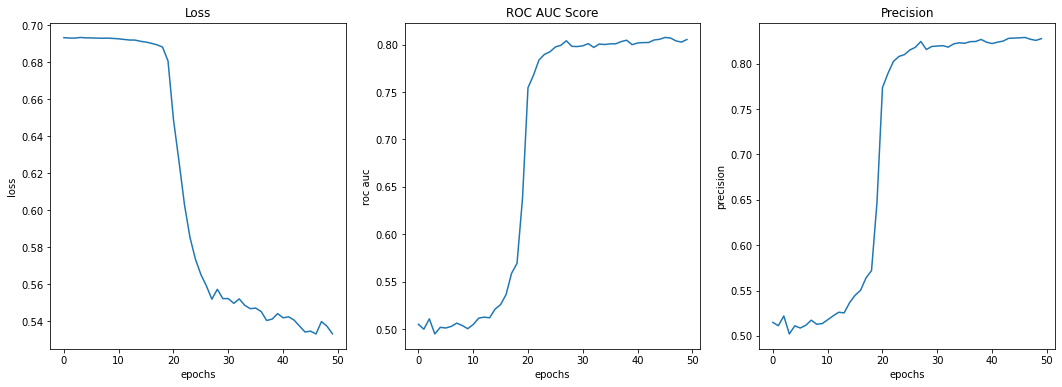

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(history['loss'].numpy())
axs[0].set(xlabel='epochs', ylabel='loss')
axs[0].set_title("Loss")

axs[1].plot(history['roc_auc'].numpy())
axs[1].set(xlabel='epochs', ylabel='roc auc')
axs[1].set_title("ROC AUC Score")

axs[2].plot(history['precision'].numpy())
axs[2].set(xlabel='epochs', ylabel='precision')
axs[2].set_title("Precision")

## Experiment 3:  Each-10% Common Neighbor

In [97]:
EPOCHS = 50
BATCH_SIZE = 500
LR = 0.001

dataset = NodePairDataset("train_features.csv", "train_labels.csv")

all_features = [i for i in range(40)] # total feature number = 40
feature_idx = all_features[7:27]
net = LinkPredictNetwork(features=feature_idx, hiddens=[2, 1, 0.5, 0.5], dropouts = False).cuda()
optimizer = optim.Adam(net.parameters(), lr=LR)

history = {
    'loss': torch.zeros(EPOCHS),
    'roc_auc': torch.zeros(EPOCHS),
    'precision': torch.zeros(EPOCHS)
}

for epoch in range(EPOCHS):
    print(epoch, end=" ")

    loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

    losses = []
    roc_aucs = []
    precisions = []
    for x, y in loader:

        optimizer.zero_grad()
        z = net(x.cuda())

        loss = BinaryCrossEntropyLoss(z, y.cuda())

        loss.backward()
        optimizer.step()

        roc = roc_auc(z.cpu().detach(), y)
        pre = precision(z.cpu().detach(), y)

        losses.append(loss.item())
        roc_aucs.append(roc)
        precisions.append(pre)

    history['loss'][epoch] = torch.tensor(losses, dtype=torch.float).mean().item()
    history['roc_auc'][epoch] = torch.tensor(roc_aucs, dtype=torch.float).mean().item()
    history['precision'][epoch] = torch.tensor(precisions, dtype=torch.float).mean().item()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Precision')

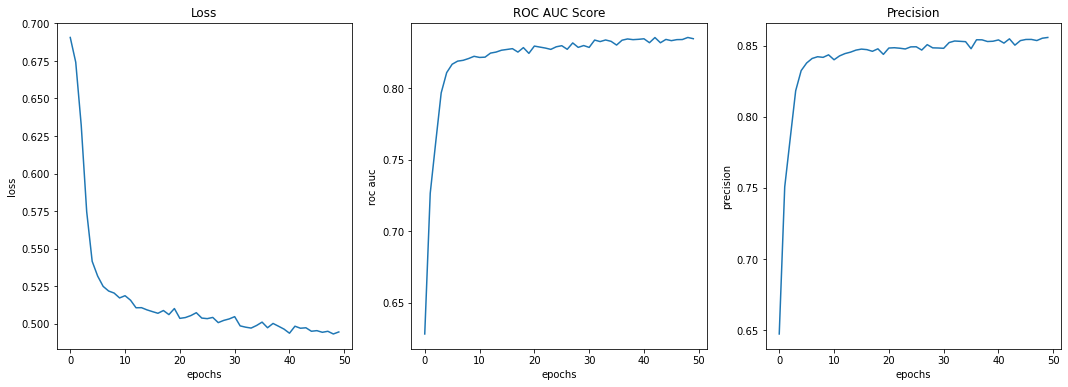

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(history['loss'].numpy())
axs[0].set(xlabel='epochs', ylabel='loss')
axs[0].set_title("Loss")

axs[1].plot(history['roc_auc'].numpy())
axs[1].set(xlabel='epochs', ylabel='roc auc')
axs[1].set_title("ROC AUC Score")

axs[2].plot(history['precision'].numpy())
axs[2].set(xlabel='epochs', ylabel='precision')
axs[2].set_title("Precision")

## Experiment 4: Each-25% Common Neighbor

In [99]:
EPOCHS = 50
BATCH_SIZE = 500
LR = 0.001

dataset = NodePairDataset("train_features.csv", "train_labels.csv")

all_features = [i for i in range(40)] # total feature number = 40
feature_idx = all_features[27:35]
net = LinkPredictNetwork(features=feature_idx, hiddens=[2, 1, 0.5, 0.5], dropouts = False).cuda()
optimizer = optim.Adam(net.parameters(), lr=LR)

history = {
    'loss': torch.zeros(EPOCHS),
    'roc_auc': torch.zeros(EPOCHS),
    'precision': torch.zeros(EPOCHS)
}

for epoch in range(EPOCHS):
    print(epoch, end=" ")

    loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

    losses = []
    roc_aucs = []
    precisions = []
    for x, y in loader:

        optimizer.zero_grad()
        z = net(x.cuda())

        loss = BinaryCrossEntropyLoss(z, y.cuda())

        loss.backward()
        optimizer.step()

        roc = roc_auc(z.cpu().detach(), y)
        pre = precision(z.cpu().detach(), y)

        losses.append(loss.item())
        roc_aucs.append(roc)
        precisions.append(pre)

    history['loss'][epoch] = torch.tensor(losses, dtype=torch.float).mean().item()
    history['roc_auc'][epoch] = torch.tensor(roc_aucs, dtype=torch.float).mean().item()
    history['precision'][epoch] = torch.tensor(precisions, dtype=torch.float).mean().item()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Precision')

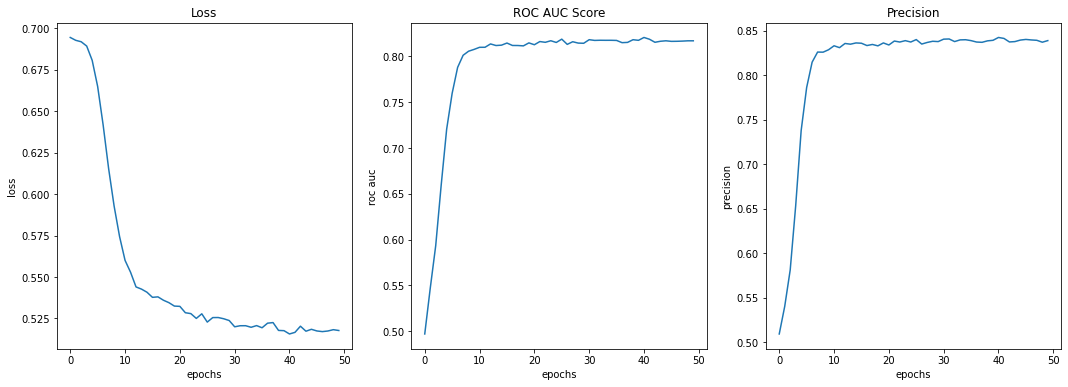

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(history['loss'].numpy())
axs[0].set(xlabel='epochs', ylabel='loss')
axs[0].set_title("Loss")

axs[1].plot(history['roc_auc'].numpy())
axs[1].set(xlabel='epochs', ylabel='roc auc')
axs[1].set_title("ROC AUC Score")

axs[2].plot(history['precision'].numpy())
axs[2].set(xlabel='epochs', ylabel='precision')
axs[2].set_title("Precision")

## Experiment 5: Global Distribution

In [105]:
EPOCHS = 50
BATCH_SIZE = 500
LR = 0.001

dataset = NodePairDataset("train_features.csv", "train_labels.csv")

all_features = [i for i in range(40)] # total feature number = 40
feature_idx = all_features[35:40]
net = LinkPredictNetwork(features=feature_idx, hiddens=[2, 1, 0.5, 0.5], dropouts = False).cuda()
optimizer = optim.Adam(net.parameters(), lr=LR)

history = {
    'loss': torch.zeros(EPOCHS),
    'roc_auc': torch.zeros(EPOCHS),
    'precision': torch.zeros(EPOCHS)
}

for epoch in range(EPOCHS):
    print(epoch, end=" ")

    loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

    losses = []
    roc_aucs = []
    precisions = []
    for x, y in loader:

        optimizer.zero_grad()
        z = net(x.cuda())

        loss = BinaryCrossEntropyLoss(z, y.cuda())

        loss.backward()
        optimizer.step()

        roc = roc_auc(z.cpu().detach(), y)
        pre = precision(z.cpu().detach(), y)

        losses.append(loss.item())
        roc_aucs.append(roc)
        precisions.append(pre)

    history['loss'][epoch] = torch.tensor(losses, dtype=torch.float).mean().item()
    history['roc_auc'][epoch] = torch.tensor(roc_aucs, dtype=torch.float).mean().item()
    history['precision'][epoch] = torch.tensor(precisions, dtype=torch.float).mean().item()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Precision')

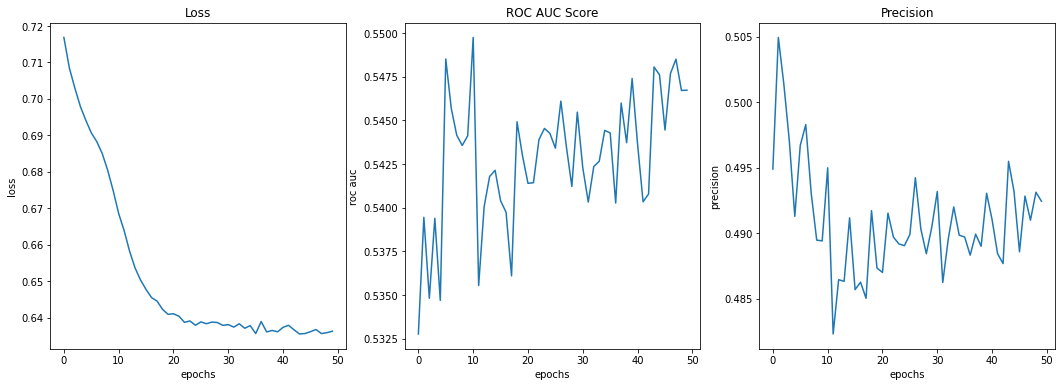

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(history['loss'].numpy())
axs[0].set(xlabel='epochs', ylabel='loss')
axs[0].set_title("Loss")

axs[1].plot(history['roc_auc'].numpy())
axs[1].set(xlabel='epochs', ylabel='roc auc')
axs[1].set_title("ROC AUC Score")

axs[2].plot(history['precision'].numpy())
axs[2].set(xlabel='epochs', ylabel='precision')
axs[2].set_title("Precision")